# Project: Predicting the cost of health insurance for a person

# Step 1: Import Essential Libraries 

In [1]:
# Libraries specialized "expert kits" to plug into Python essential for EDA.
import requests
import os
from pathlib import Path
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import json
from numpy._core.defchararray import upper
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
import pickle # -- Binary (unreadable by humans) -- Can save almost any Python object -- Very fast for complex objects --
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import RidgeCV, LassoCV


# Step 2: Problem Statement / Data Collection
## 2.1 Description of the Problem

    The important insurance company 4Geeks Insurance S.L. wants to calculate, based on the physiological data of its customers what will be the premium (cost) to be borne by each of them. To do this, it has assembled a whole team of doctors, and based on data from other companies and a particular study, it has managed to gather a set of data to train a predictive model.

## 2.2 Inicitial Loading and Inspection

In [2]:
def setup_project_structure(base_path, subfolders):
    """Creates a standard data science directory tree."""
    for folder in subfolders:
        folder_path = Path(base_path) / folder
        folder_path.mkdir(parents=True, exist_ok=True)
    print(f"Project structure initialized in: {base_path}")

def download_dataset_to_raw(url, full_path):
    """Downloads a file to a specific path."""
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(full_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
            
        print(f"Download successful! Saved to: {full_path}")
        return True
    except Exception as e:
        print(f"Download failed: {e}")
        return False

    except requests.exceptions.RequestException as e:
        print(f"An error occurred during the download: {e}")
        return False
    
# --- CONFIGURATION ---
BASE_DIR = "../data"
FOLDERS = ["raw", "processed", "interim"]
DATA_URL = "https://breathecode.herokuapp.com/asset/internal-link?id=416&path=medical_insurance_cost.csv"
TARGET_FILE = "medical_insurance_cost.csv"

# EXECUTION
# Build the whole house
setup_project_structure(BASE_DIR, FOLDERS)

# Put the data in the 'raw' room
RAW_FILE_PATH = Path(BASE_DIR) / "raw" / TARGET_FILE
download_dataset_to_raw(DATA_URL, RAW_FILE_PATH)

Project structure initialized in: ../data
Download successful! Saved to: ../data/raw/medical_insurance_cost.csv


True

In [3]:
# Define the full path again for reading
try:
    df = pd.read_csv(RAW_FILE_PATH, sep= None, engine= 'python')
    print("\nDataset loaded successfully into a DataFrame:")
    print(tabulate(df.head(), headers= "keys", tablefmt= "psql"))
except FileNotFoundError:
    print(f"\nError: File not found at {RAW_FILE_PATH}")


Dataset loaded successfully into a DataFrame:
+----+-------+--------+--------+------------+----------+-----------+-----------+
|    |   age | sex    |    bmi |   children | smoker   | region    |   charges |
|----+-------+--------+--------+------------+----------+-----------+-----------|
|  0 |    19 | female | 27.9   |          0 | yes      | southwest |  16884.9  |
|  1 |    18 | male   | 33.77  |          1 | no       | southeast |   1725.55 |
|  2 |    28 | male   | 33     |          3 | no       | southeast |   4449.46 |
|  3 |    33 | male   | 22.705 |          0 | no       | northwest |  21984.5  |
|  4 |    32 | male   | 28.88  |          0 | no       | northwest |   3866.86 |
+----+-------+--------+--------+------------+----------+-----------+-----------+


# Step 3: Exploration and Data Cleaning
## 3.1 Dataset Variables Description
* **Variables**
    1. **age.** Age of primary beneficiary (numeric)
    2. **sex.** Gender of the primary beneficiary (categorical)
    3. **bmi.** Body mass index (numeric)
    4. **children.** Number of children/dependents covered by health insurance (numeric)
    5. **smoker.** Is the person a smoker? (categorical)
    6. **region.** Beneficiary's residential area in the U.S.: northeast, southeast, southwest, northwest (categorical)
    7. **charges.** Health insurance premium (numerical). **THIS IS THE TARGET**

## 3.2 DataSet Dimension & Tipology Visibility

In [4]:
row, col = df.shape
print(f"The Dataset has {row} number of rows and {col} columns.")

The Dataset has 1338 number of rows and 7 columns.


## 3.3 Top 5 Row View

In [5]:
top_five_data = df.head()
print("These are the DataSet top 5 columns view to be analized:")
print(tabulate(top_five_data, headers='keys', tablefmt='psql'))

These are the DataSet top 5 columns view to be analized:
+----+-------+--------+--------+------------+----------+-----------+-----------+
|    |   age | sex    |    bmi |   children | smoker   | region    |   charges |
|----+-------+--------+--------+------------+----------+-----------+-----------|
|  0 |    19 | female | 27.9   |          0 | yes      | southwest |  16884.9  |
|  1 |    18 | male   | 33.77  |          1 | no       | southeast |   1725.55 |
|  2 |    28 | male   | 33     |          3 | no       | southeast |   4449.46 |
|  3 |    33 | male   | 22.705 |          0 | no       | northwest |  21984.5  |
|  4 |    32 | male   | 28.88  |          0 | no       | northwest |   3866.86 |
+----+-------+--------+--------+------------+----------+-----------+-----------+


## 3.4 Data Types and Non-Nulls Values Overview.

In [6]:
print("This is the information about Non-Null and Dtype:\n================================================")
print(df.info())

This is the information about Non-Null and Dtype:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


## 3.5 Check Unique

In [7]:
print("These are the Unique Values for each columns on the Dataset:\n============================================================")
print(df.nunique())

These are the Unique Values for each columns on the Dataset:
age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64


### 3.5.1 Conclusions about the data info:
- There is a total of 1338 rows and 7 columns.
- INTEGER Dtype are 2 int64 columns.
- FLOAT Dtype are 2 float64.
- OBJECT Dtype are 3 object.
### Non-Null checking:
- int64: 100% ok.
- float64: 100% ok.
- object: 100% ok. 

## 3.6 Check for Duplicates Values

In [8]:
# Since there are no identifiers, duplicate check looked at the entire row.
duplicate_val = df.duplicated().sum()
print(f"There is << {duplicate_val} >> duplicated value in the dataset.")

There is << 1 >> duplicated value in the dataset.


## 3.7 Duplicates Inspection

In [9]:
# Finding those 12 duplicates is a vital cleaning step.
duplicate_rows = df[df.duplicated(keep= False)]
print("Table with duplicates rows:\n======================================================")
print(tabulate(duplicate_rows.head(24), headers= "keys", tablefmt= "psql"))

Table with duplicates rows:
+-----+-------+-------+-------+------------+----------+-----------+-----------+
|     |   age | sex   |   bmi |   children | smoker   | region    |   charges |
|-----+-------+-------+-------+------------+----------+-----------+-----------|
| 195 |    19 | male  | 30.59 |          0 | no       | northwest |   1639.56 |
| 581 |    19 | male  | 30.59 |          0 | no       | northwest |   1639.56 |
+-----+-------+-------+-------+------------+----------+-----------+-----------+


## 3.8 Drop Duplicates

In [10]:
df = df.drop_duplicates().reset_index(drop= True)
print(df.shape)
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

(1337, 7)
+----+-------+--------+--------+------------+----------+-----------+-----------+
|    |   age | sex    |    bmi |   children | smoker   | region    |   charges |
|----+-------+--------+--------+------------+----------+-----------+-----------|
|  0 |    19 | female | 27.9   |          0 | yes      | southwest |  16884.9  |
|  1 |    18 | male   | 33.77  |          1 | no       | southeast |   1725.55 |
|  2 |    28 | male   | 33     |          3 | no       | southeast |   4449.46 |
|  3 |    33 | male   | 22.705 |          0 | no       | northwest |  21984.5  |
|  4 |    32 | male   | 28.88  |          0 | no       | northwest |   3866.86 |
+----+-------+--------+--------+------------+----------+-----------+-----------+


## 3.9 Eliminate Irrelevant Information

- I will not drop any variable as the number of columns or variable is very small for this data set.
- Let's see how the model will perform with the variable analysis and I might see if any variable is just noise so I can delete it


In [11]:
# df = df.drop([define columns in case of irrelevant info], axis= 1)
# print(tabulate(df.head(), headers= "keys", tablefmt= "psql"))

# Step 4: Analysis of Univariate Variables
## 4.1 Categorical Variable Analysis

In [12]:
# Select only columns with 'object' data type (strings/categories)
categorical_val = df.select_dtypes(include= ['object']).columns.tolist()
print(f"Categorical Variables: {categorical_val}")

Categorical Variables: ['sex', 'smoker', 'region']


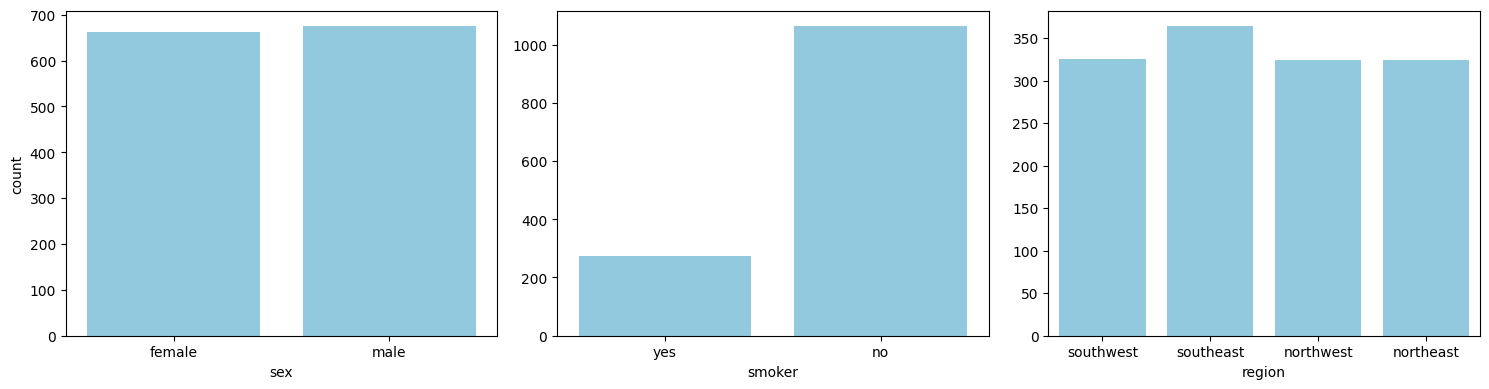

In [13]:
# Creating countplots for the categorical variables
# It is better to use countplot to visualize the behavior 
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize = (15, 4 * nrows))
axes_flat = axes.flatten()

for i, col in enumerate(categorical_val):
    if i < len(axes_flat):
        sns.countplot(data = df, x= col,  ax = axes_flat[i], orient= 'v', color= "skyblue")
    if i >= 1:
        axes_flat[i].set(ylabel= None)
    
    # Hide any unused subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout()
plt.show()

### 4.1.1 Conclusions on Countplot for Categorical Variables
- **The Target (y)**: The "no" bars are massive compared to the "yes" bars. This confirms an imbalance (roughly 90% No vs. 10% Yes).
- **The (default) Column**: Almost every single person is in the "no" or "unknown" category. There are very few "yes" cases. Because there is almost no variation here, this column likely won't help the model predict a "yes" subscription. It’s a strong candidate for deletion.
- **Seasonality (month)**: There is a huge spike in May. This suggests the bank is very active in the spring. We might check if the "yes" rate is higher in smaller months like September or December.
- **Column (poutcome)**: While most are "nonexistent," the "success" category is small but might be powerful. If a customer said yes before, they are highly likely to say yes again.
- **Job & Education**: there are a lot of categories here. For the Logistic Regression, these are the largest groups. they might be to be factorized in order to be able to rank them with numbers.

## 4.2 Numeric Variables Analysis

In [14]:
# Select only columns with 'int or float' data type (numeric
numerics = df.select_dtypes(include= ['number']).columns.tolist()
print(f"Numeric variables: {numerics}")

Numeric variables: ['age', 'bmi', 'children', 'charges']


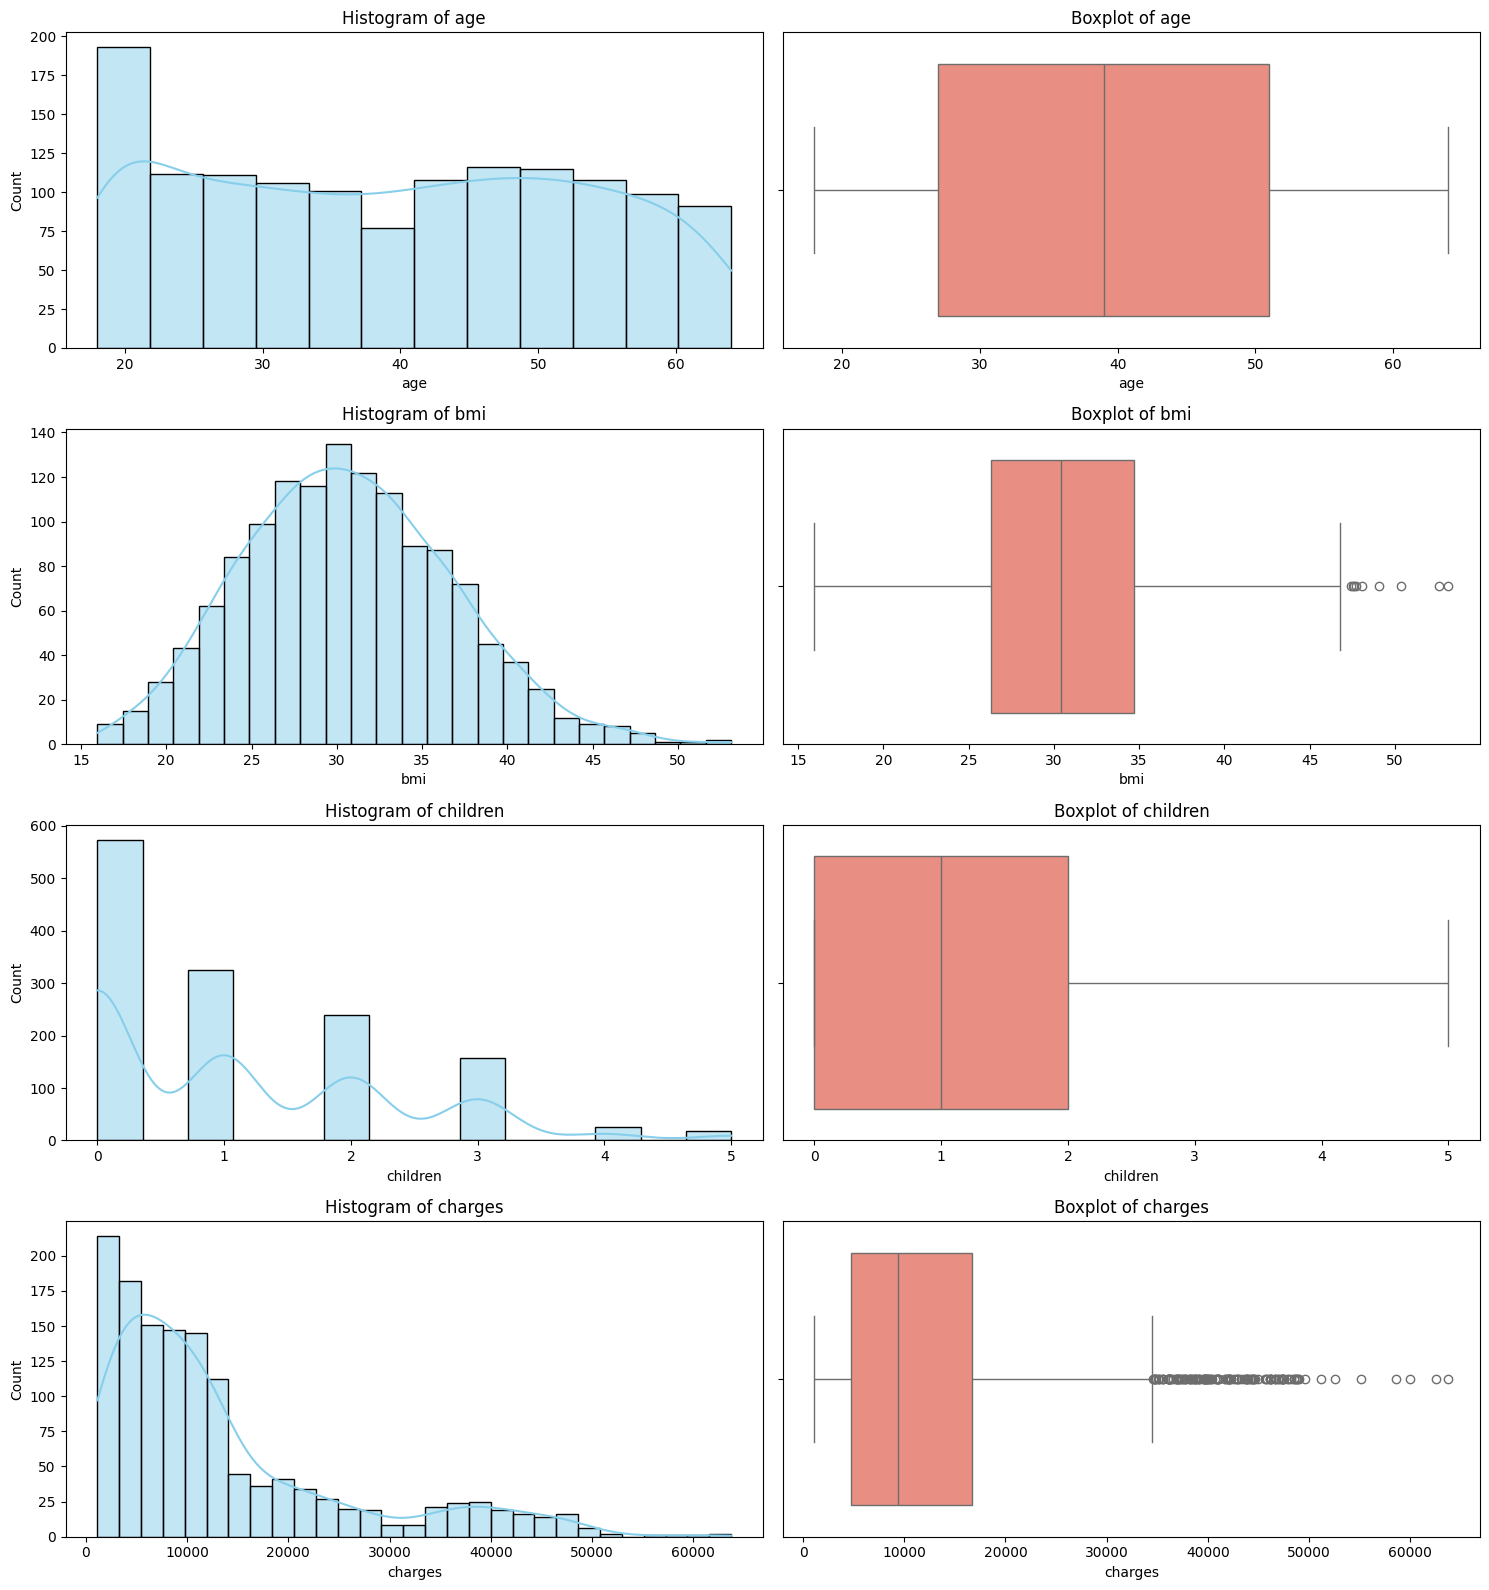

In [15]:
# Creating histplot and boxplot for the numeric variables
nrows = len(numerics)
ncols = 2
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize=(15, 4 * nrows))

for i, col in enumerate(numerics):
    sns.histplot(df[col], kde=True, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f'Histogram of {col}')
    sns.boxplot(x=df[col], ax=axes[i, 1], color="salmon")
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

### 4.2.1 Conclusions for Numerical Variable Charts
- **age**: There is a noticeable "spike" at the very beginning (around age 18-20). Could be many young adults are entering the system for the first time.
- **BMI**: In medical terms, a BMI over 30 is considered obese. The median is right at 30, more than half of the dataset falls into a higher-risk category.
- **Children**: It is rare to see 4 or 5 children in this data. Most people in the dataset have 0 children, and the count drops off sharply as the number of children increases.
- **Charges**: Heavily Right-Skewed. The boxplot is covered in outliers! These could be the "high-risk" individuals.

# Step 5: Multivariate Variables Analysis
## 5.1 Numerical-Numerical Analysis

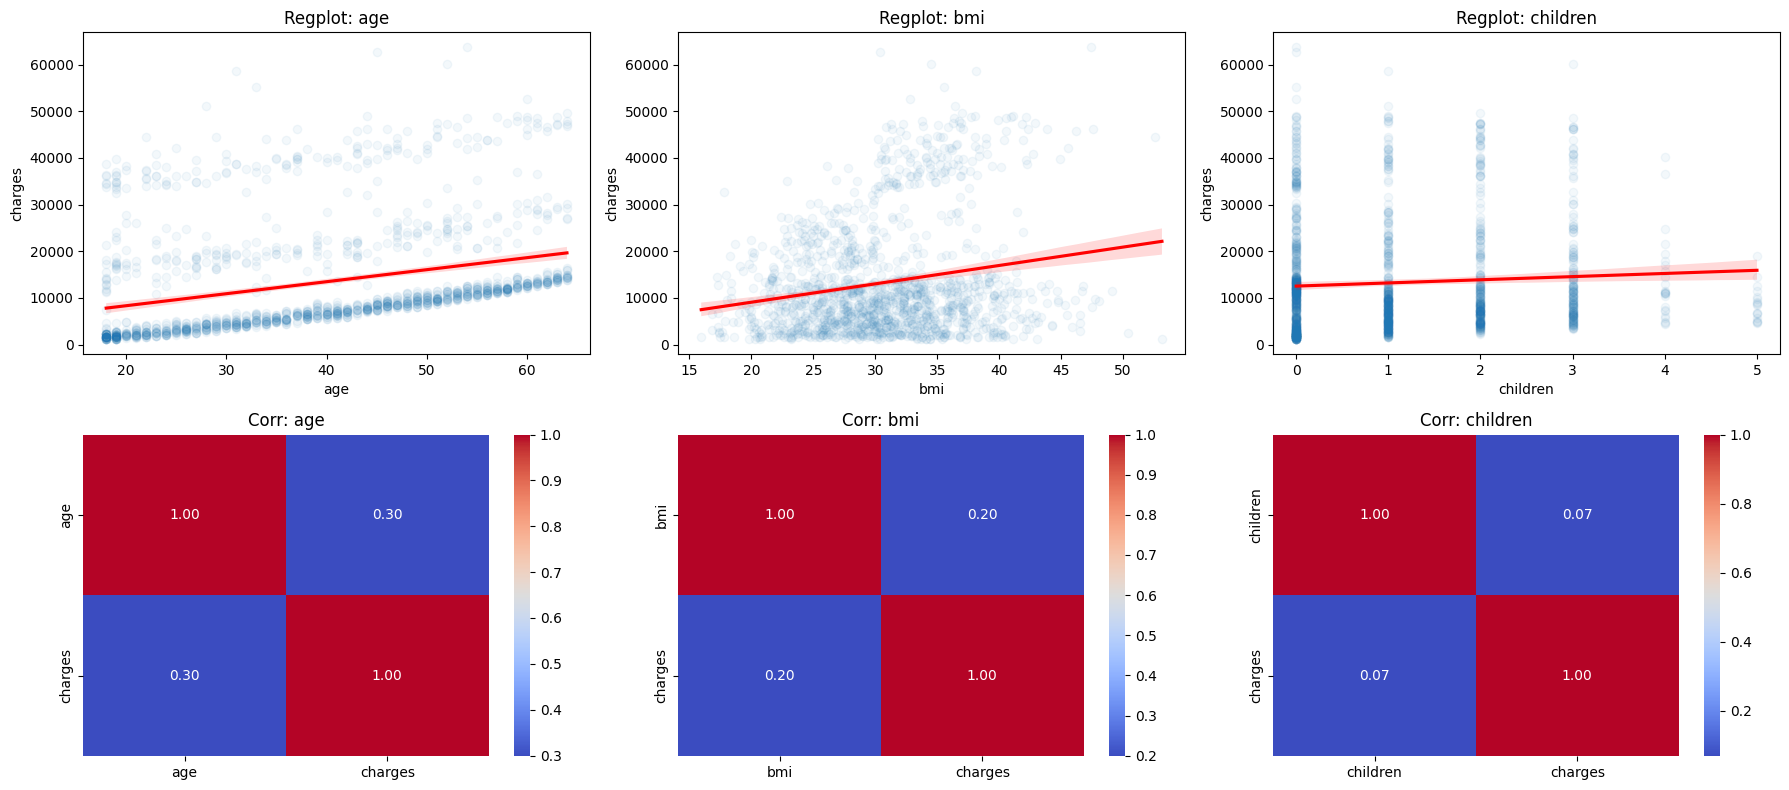

In [16]:
# Numeric variables: ['age', 'bmi', 'children', 'charges']
# 2. Excluding the target. The condition is to avoid ploting the target with itself.
if 'charges' in numerics: numerics.remove('charges')

# 3. Calculate Grid Size
ncols = 3
group_chart = math.ceil(len(numerics) / ncols)
nrows = group_chart * 2 # Double the rows (one for Reg, one for Heatmap)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4 * nrows))

for chart_idx in range(group_chart):
    # Determine which row we are on for Regplots
    reg_row = chart_idx * 2
    # The Heatmap row is always the one right below it
    heat_row = reg_row + 1

    # Get the 3 variables for this group
    start = chart_idx * ncols
    end = start + ncols
    current_vars = numerics[start:end]

    for col_idx, col in enumerate(current_vars):
        # --- Plot 1: Regplot ---
        sns.regplot(data= df, x= col, y= 'charges', ax= axes[reg_row, col_idx], scatter_kws={'alpha':0.05}, line_kws={'color':'red'})
        axes[reg_row, col_idx].set_title(f'Regplot: {col}')
        # --- Plot 2: Heatmap ---
        sns.heatmap(df[[col, 'charges']].corr(), annot=True, fmt=".2f", ax=axes[heat_row, col_idx], cmap='coolwarm')
        axes[heat_row, col_idx].set_title(f'Corr: {col}')
# 4. Hide empty slots (if any)
for col_idx in range(len(current_vars), ncols):
    axes[reg_row, col_idx].set_visible(False)
    axes[heat_row, col_idx].set_visible(False)

plt.tight_layout()
plt.show()

### 5.1.1 Conclusion Num-Num analysis
- **Age**: Notice those three distinct lines of dots. The red regression line has a positive slope, confirming that age is the strongest numerical driver of cost among the three.
- **BMI**: There is a positive correlation, but the dots are much more scattered (like a cloud) compared to age. Most people are clustered below $15,000 regardless of BMI, but as BMI passes 30, we see a "breakout" of high-cost cases reaching $40,000+.
- **Children**: The regression line is almost flat. While children might add a small flat fee to a plan, they aren't a primary driver of medical cost volatility in this dataset.

## 5.2 Num - Num Analysis (other predictors)

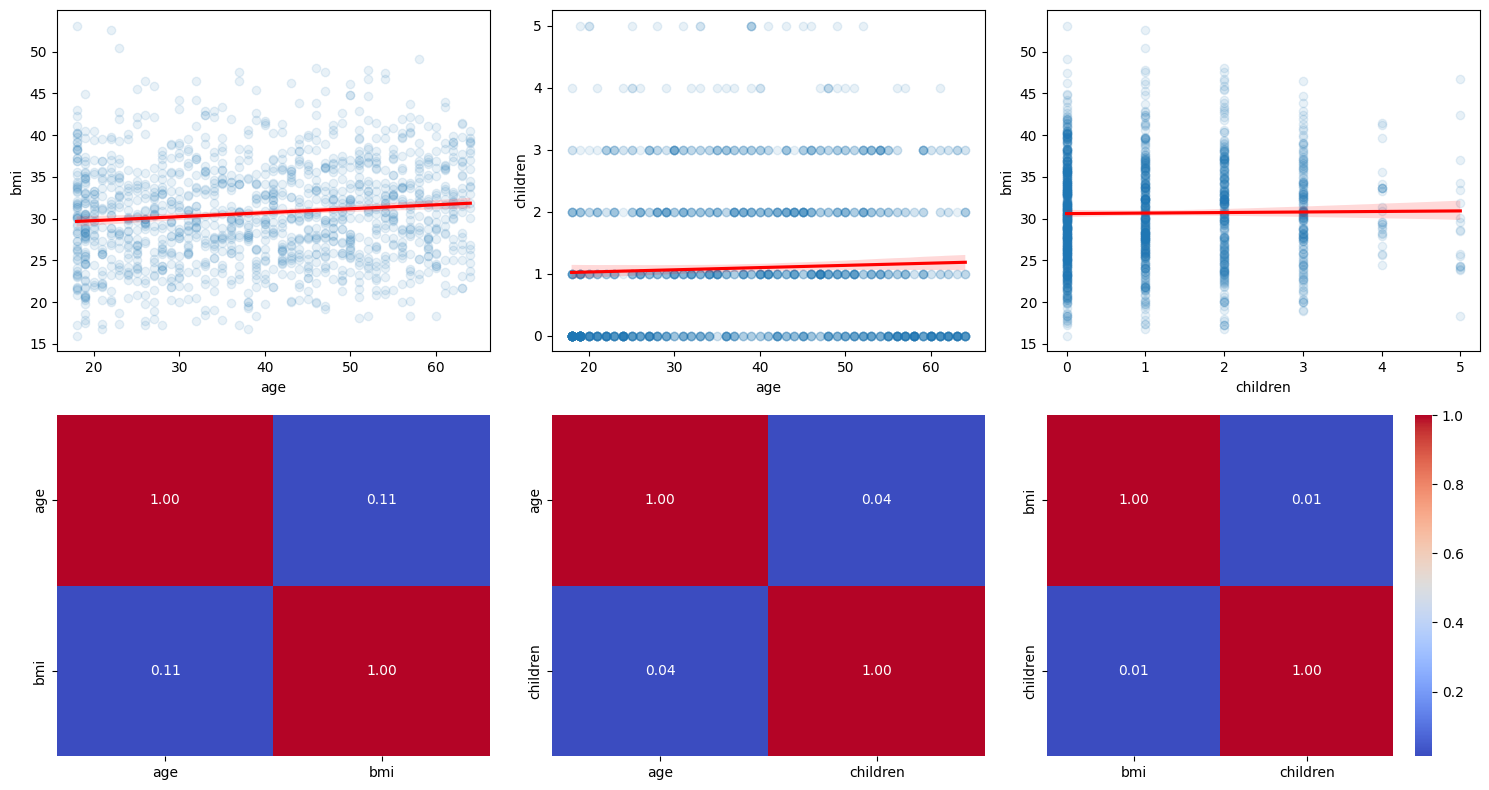

In [17]:
# A quick checking for Multicollinearity between two specific predictors
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize=(5 * ncols, 4 * nrows))

sns.regplot(data=df, ax=axes[0, 0], x='age', y='bmi', scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
sns.heatmap(df[['age', 'bmi']].corr(), annot=True, fmt=".2f", ax=axes[1, 0], cbar=False, cmap='coolwarm')

sns.regplot(data=df, ax=axes[0, 1], x='age', y='children', scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
sns.heatmap(df[['age', 'children']].corr(), annot=True, fmt=".2f", ax=axes[1, 1], cbar=False, cmap='coolwarm')

sns.regplot(data=df, ax=axes[0, 2], x='children', y='bmi', scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
sns.heatmap(df[['bmi', 'children']].corr(), annot=True, fmt=".2f", ax=axes[1, 2], cmap='coolwarm')

plt.tight_layout()
plt.show()

### 5.2.1 Conclusion Num-Num (others predictors)
- **Age vs. BMI (0.11)**: There is a very slight trend of BMI increasing with age, but it is weak. This is good for modeling, as it means Age and BMI provide independent information to the model.
- **Age vs. Children (0.04)**: No correlation. The dataset contains people with children across all age brackets fairly evenly.
- **BMI vs. Children (0.01)**: Zero correlation. A person's BMI is entirely independent of how many children they have.

## 5.3 Categorical-Categorical Analysis

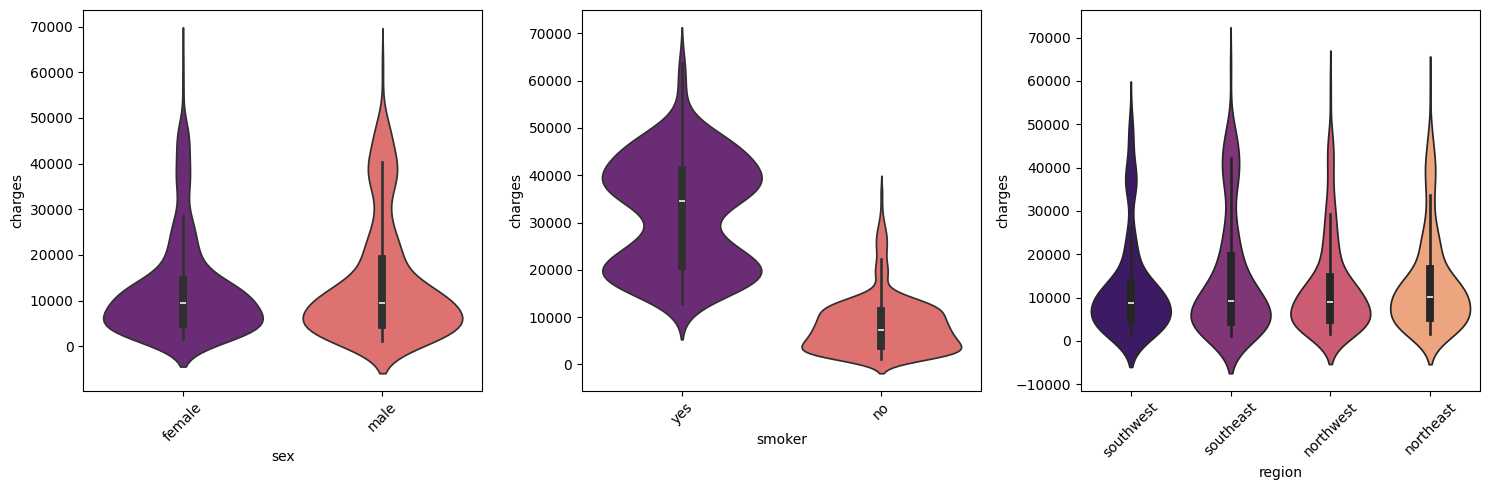

In [18]:
# Categorical Variables: ['sex', 'smoker', 'region']
if 'charges' in categorical_val: categorical_val.remove('charges')
ncols = 3
nrows = math.ceil(len(categorical_val) / ncols)
fig, axes = plt.subplots(nrows= nrows, ncols= ncols , figsize = (15, 5 * nrows))
axes_flat = axes.flatten()

for i, col in enumerate(categorical_val):
    sns.violinplot(ax = axes_flat[i], data = df, x = col, y= 'charges', hue= col, palette='magma')
    axes_flat[i].tick_params(axis= 'x', rotation= 45)

for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout()
plt.show()

### 5.3.1 Conclusion Cat - Cat Analysis
* **Smoker**:
    - **The Non-Smoker**: The "no" category has a very wide base at the bottom, meaning the vast majority of non-smokers are clustered at the lowest possible cost level.
    - **The Smoker**: Notice the two distinct bellies in the yes violin. The lower belly (around $20k). The upper belly (around $40k).
* **Sex**:
    - **Similar Bases**: The bottom "fat" part of the violin is almost identical for both, meaning the "average" baseline cost is similar for men and women.
    - **The Tip of the Violin**: Notice that the "male" violin stretches slightly higher and is a bit "thicker" in the $40k+ range.
* **Region**:
    - **Consistency**: Most regions look very similar, with a large cluster of people at the low end.

## 5.4 Combinations of smoker with Others Predictors

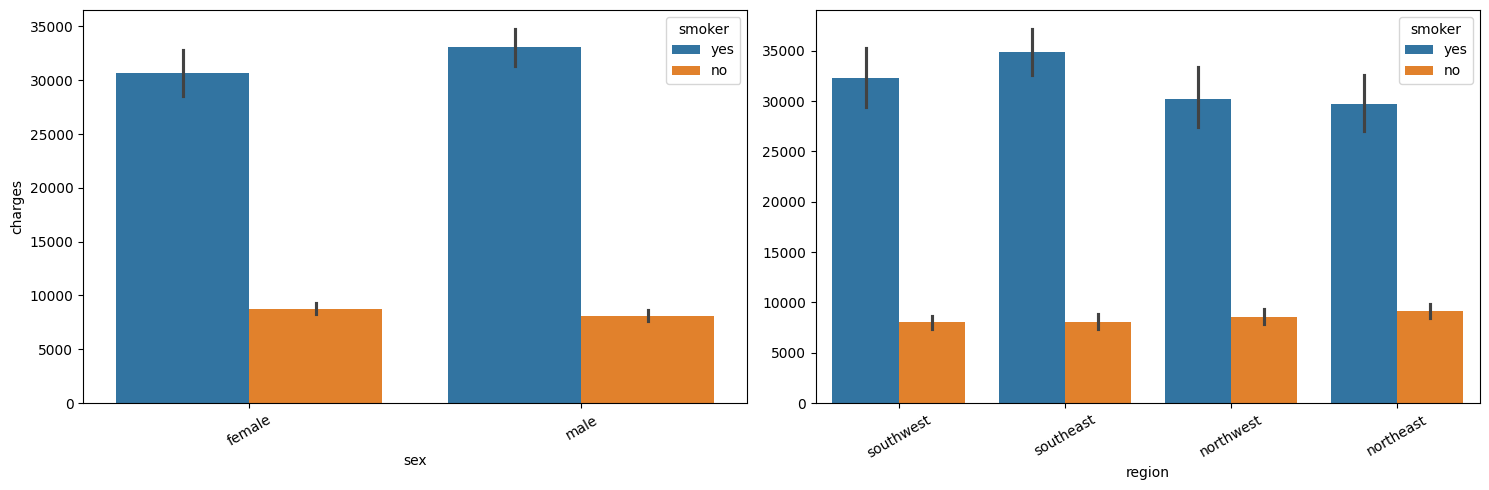

In [19]:
# Creating barplot charts with various predictors
interaction_vars = ['sex', 'region']
fig, axis = plt.subplots(figsize = (15, 5), ncols = 2)

for i, col in enumerate(interaction_vars):
    sns.barplot(ax = axis[i], data = df, x = col, y = "charges", hue = "smoker")
    axis[i].tick_params(axis= 'x', rotation= 30)
    axis[i].legend(title= 'smoker', loc= 'upper right')
    if i > 0:
        axis[i].set(ylabel= None)

plt.tight_layout()
plt.show()

### 5.4.1 Conclusion poutcome vs. others Predictors
- Interestingly, male smokers show a slightly higher average charge than female smokers. This suggests that the "interaction" between being male and being a smoker might lead to even higher insurance risks than for female smokers.
- the region, this reinforces the earlier violin plot observation. The Southeast isn't just more expensive in general; it’s specifically more expensive for its smoker population.

# 5.5 Correlation / Factorize Analysis
In order to seize all variable in a heatmap plot analysis, I will factorize categorical variables and save them in a json.
Categorical variables: ['sex', 'smoker', 'region']

In [20]:
categorical_vars = ['sex', 'smoker']
categorical_num = [var + '_num' for var in categorical_vars]
# Categorical factorization
for col in categorical_num:
    no_num_col = col[:-4]
    df[str(col)] = pd.factorize(df[no_num_col])[0]
# Visibility of the last loop to see factorization
print(tabulate(df[[no_num_col, col]].head(), headers='keys', tablefmt='psql'))

+----+----------+--------------+
|    | smoker   |   smoker_num |
|----+----------+--------------|
|  0 | yes      |            0 |
|  1 | no       |            1 |
|  2 | no       |            1 |
|  3 | no       |            1 |
|  4 | no       |            1 |
+----+----------+--------------+


### 5.5.1 Method pd.get_dummies
- This method gives you multiple columns of 0 and 1. This allows the model to calculate a separate price impact for each specific region rather than assuming the regions have a numerical order.

In [21]:
# Handle Region (One-Hot Encoding is safer for non-ordinal categories)
df = pd.get_dummies(df, columns= ['region'], drop_first=True, dtype= int)

In [22]:
df

,age,sex,bmi,children,smoker,charges,sex_num,smoker_num,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,16884.92400,0,0,0,0,1
1,18,male,33.770,1,no,1725.55230,1,1,0,1,0
2,28,male,33.000,3,no,4449.46200,1,1,0,1,0
3,33,male,22.705,0,no,21984.47061,1,1,1,0,0
4,32,male,28.880,0,no,3866.85520,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,10600.54830,1,1,1,0,0
1333,18,female,31.920,0,no,2205.98080,0,1,0,0,0
1334,18,female,36.850,0,no,1629.83350,0,1,0,1,0
1335,21,female,25.800,0,no,2007.94500,0,1,0,0,1


## 5.6 Saving the JSON

In [23]:
# Save the json
prefix_name = '_transformation_rules'
for col in categorical_num:
    no_num_col = col[:-4]
    file_name = no_num_col + prefix_name + ".json"
    factorized_dict = {row[no_num_col]: row[col] for index, row in df[[col, no_num_col]].drop_duplicates().iterrows()}
    with open("../data/interim/" + file_name, "w") as f:
        json.dump(factorized_dict, f)

## 5.7 Num - Cat Analysis (Complete)

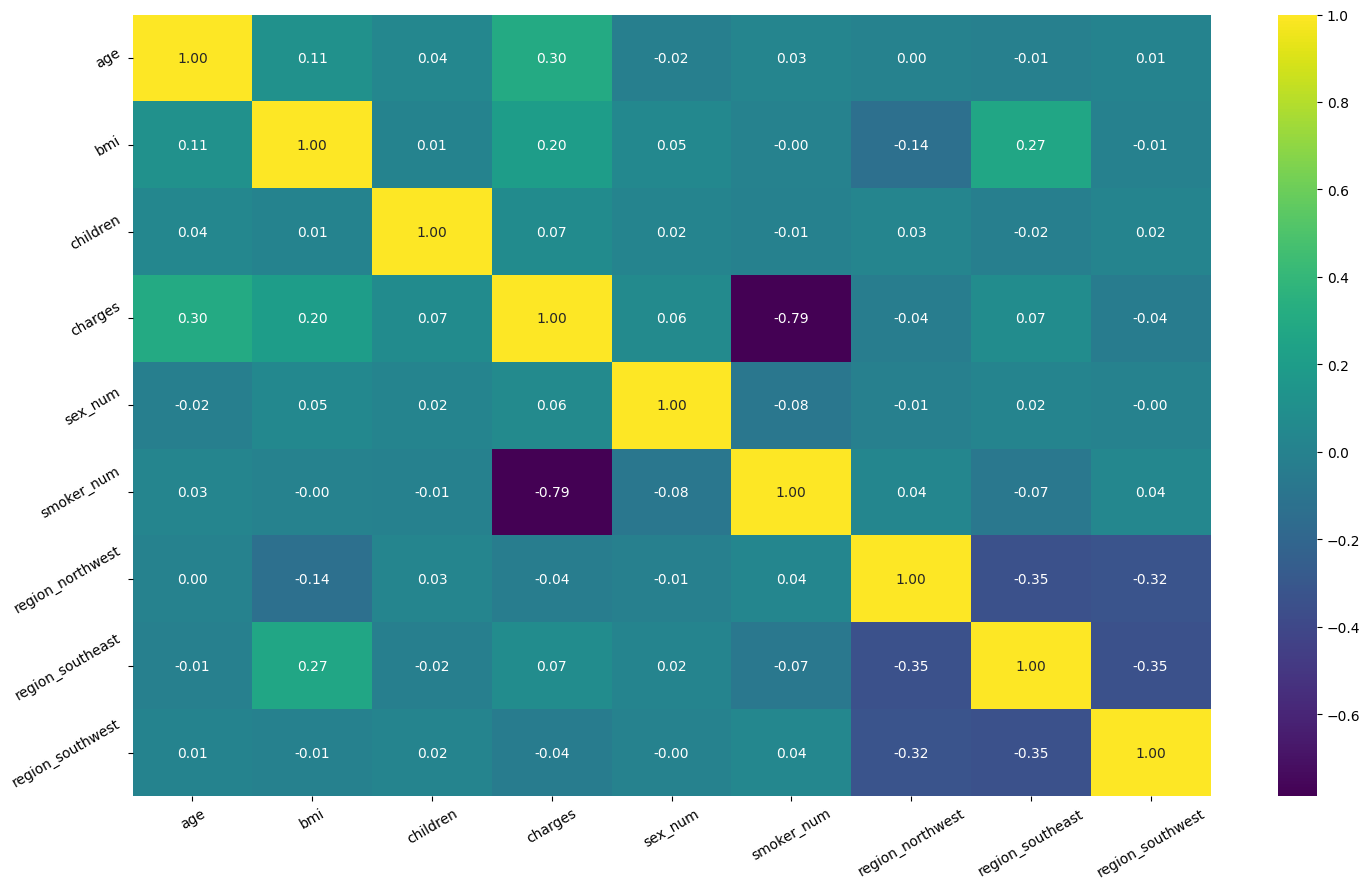

In [24]:
# Creating heatmap chart to analyze complete variables correlation
cols_num = df.select_dtypes(include=['number']).columns.tolist()
fig, ax = plt.subplots(figsize= (15, 9))
sns.heatmap(df[cols_num].corr(method="pearson"), annot=True, fmt=".2f", cmap="viridis", ax= ax).tick_params(rotation= 30)
plt.tight_layout()
plt.show()

### 5.7.1 Conclusion Correlation Heatmap

- **charges and smoker_num at -0.79**: The strongest correlation in the entire matrix. The magnitude |0.79| is what matters, it confirms that smoking is by far the most influential predictor of cost.
- **age (0.30) and bmi (0.20)**: As these numbers go up, the insurance costs tend to go up as well, though not as drastically as with smoking status.
- **age vs bmi at 0.11 or age vs children at 0.04**: The correlations are very small.  
- **sex_num and the specific region_**: (ranging from -0.04 to 0.07), they don't have a strong individual linear relationship with the cost.

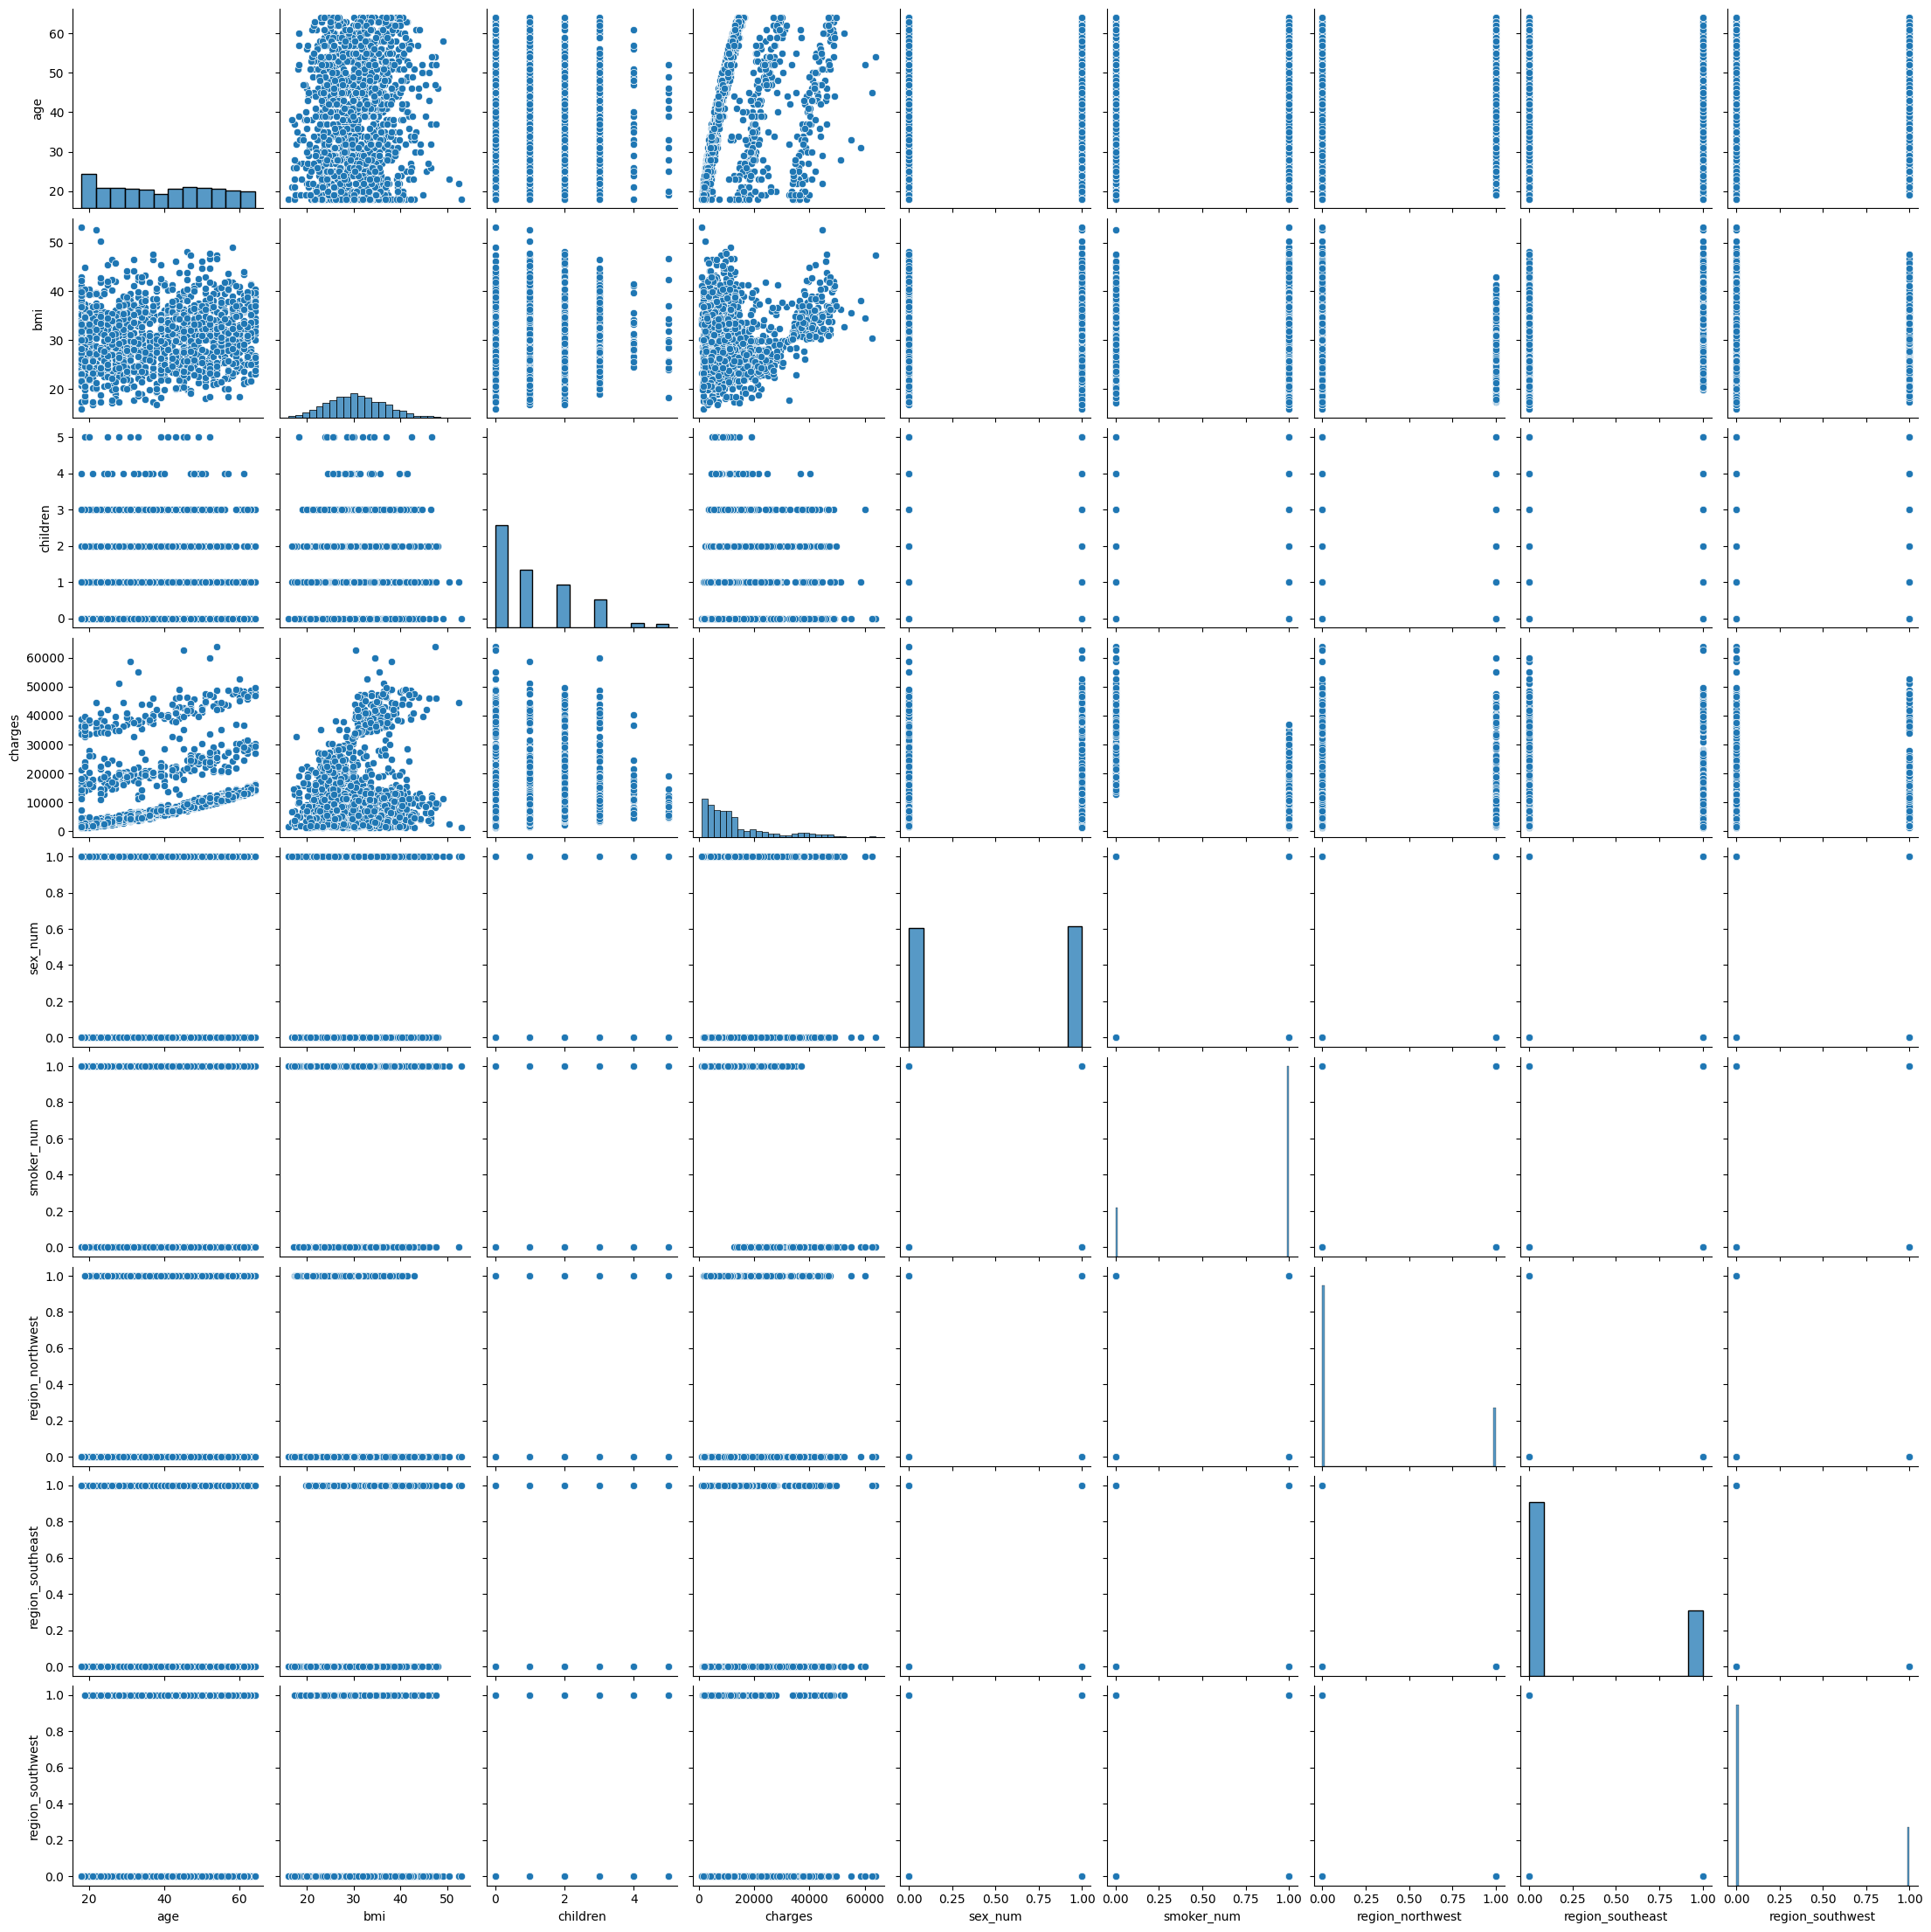

In [25]:
# Creating pairplot to have a variables behaviour visibility 
sns.pairplot(data= df)

## 5.8 Final DataSet Columns
FINAL_COLS = ['age', 'bmi', 'children', 'charges', 'sex_num', 'smoker_num', 'region_northwest', 'region_southeast', 'region_southwest']					


In [26]:
final_cols = ['age', 'bmi', 'children', 'charges', 'sex_num', 'smoker_num', 'region_northwest', 'region_southeast', 'region_southwest']
df = df[final_cols]

In [27]:
print(tabulate(df.describe(), headers= "keys", tablefmt= "psql"))

+-------+-----------+------------+------------+-----------+-------------+--------------+--------------------+--------------------+--------------------+
|       |       age |        bmi |   children |   charges |     sex_num |   smoker_num |   region_northwest |   region_southeast |   region_southwest |
|-------+-----------+------------+------------+-----------+-------------+--------------+--------------------+--------------------+--------------------|
| count | 1337      | 1337       | 1337       |   1337    | 1337        |  1337        |        1337        |        1337        |        1337        |
| mean  |   39.2221 |   30.6635  |    1.09574 |  13279.1  |    0.504862 |     0.795064 |           0.242334 |           0.272251 |           0.243082 |
| std   |   14.0443 |    6.10047 |    1.20557 |  12110.4  |    0.500163 |     0.403806 |           0.428655 |           0.445285 |           0.429104 |
| min   |   18      |   15.96    |    0       |   1121.87 |    0        |     0        |

# Step 6: Feature Engineering
## 6.1 Outlier analysis

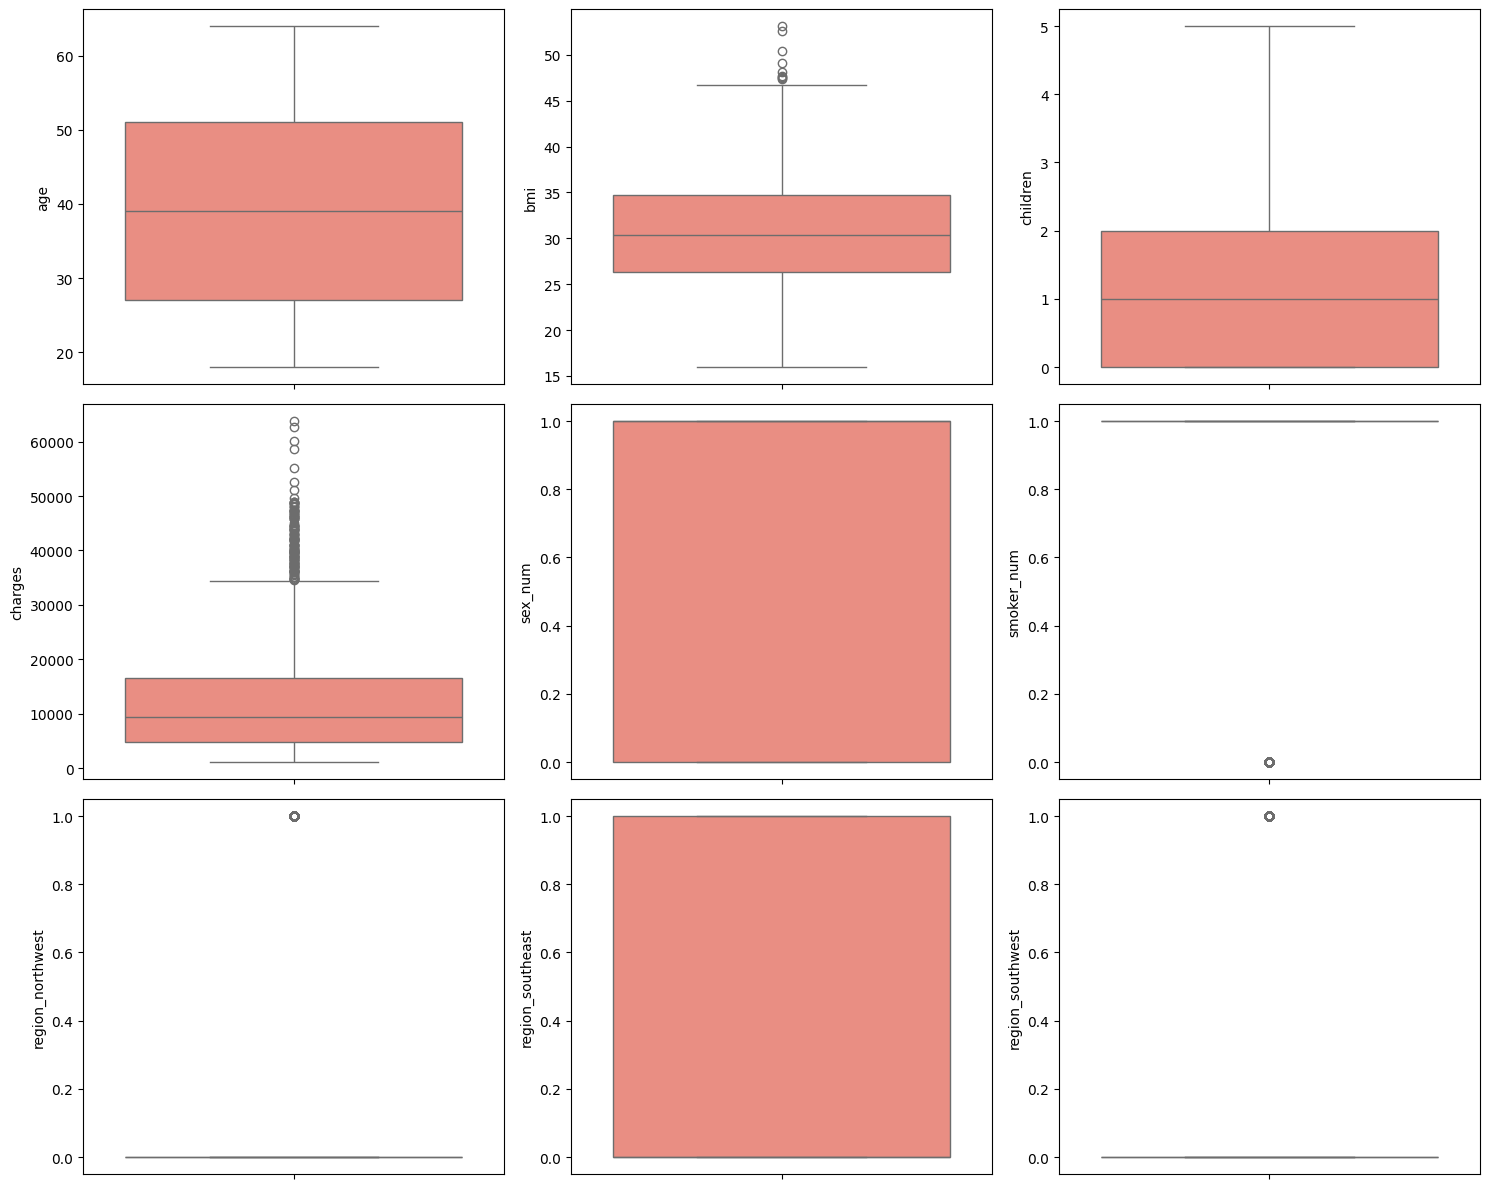

In [28]:
# Creating boxplot to understand the outliers in each variable
ncols = 3
nrows = math.ceil(len(final_cols) / ncols)
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= (15, 4 * nrows))

axes = axes.flatten()
for i, col in enumerate(final_cols):
    sns.boxplot(data= df, y= col, ax= axes[i], color= 'salmon')
for j in range(len(final_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 6.1.1 Conclusion Boxplots Charts
- **Age**: There are zero outliers. The data is perfectly contained between the ages of 18 and 64, with a median age right around 39.
- **BMI**: There are several high-side outliers (above ~47 BMI).
- **Children**: No significant outliers here.
- **Charges**: This plot is the most striking. There is a huge string of outliers starting around $35,000 and stretching all the way to +$60,000. the "outliers" are actually the most important data points because they represent the high costs associated with smoking and high BMI.
- **smoker_num, sex_num, and the region**: You can ignore "outliers" for these binary columns; they are just a reflection of the class imbalance.

* As per these conclusions. I will not alpply the method of replacing the outliers.

In [29]:
# Necessary coding to replace outliers creating upper and lower limits
# SAVING ALL DATASETS.

df_WITH_outliers = df.copy()
# df_WITHOUT_outliers = df.copy() # This need to be modified. For every variable with outliers, I will replce outliers values.

# outliers_cols = ['campaign'] # The target variable price can't be modified so we leave as it is.

# def replace_outliers(column, data_df):
#   col_stats = df[column].describe()
#   col_iqr = col_stats["75%"] - col_stats["25%"]
#   upper_limit = round(float(col_stats["75%"] + 1.5 * col_iqr), 2)
#   lower_limit = round(float(col_stats["25%"] - 1.5 * col_iqr), 2)

#   if lower_limit < 0: lower_limit = min(df[column])
#   # Let's take out upper outliers 
#   data_df[column] = data_df[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
#   # Let's take out lower outliers 
#   data_df[column] = data_df[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
#   return data_df.copy(), [lower_limit, upper_limit]

# outliers_dict = {}
# for column in outliers_cols:
#   df_WITHOUT_outliers, limits = replace_outliers(column, df_WITHOUT_outliers)
#   outliers_dict.update({column: limits})

# outliers_dict # This jason needs to be saved

In [30]:
# Saving the json dictionary for outliers limit
# with open('../data/interim/outliers_dict.json', 'w') as f:
    # json.dump(outliers_dict, f)

## 6.2 Missing Value Analysis

In [31]:
print("The list below, will show if dataset WITH outliers has any null value for the variables:")
print(df_WITH_outliers.isnull().sum().sort_values(ascending= False))

The list below, will show if dataset WITH outliers has any null value for the variables:
age                 0
bmi                 0
children            0
charges             0
sex_num             0
smoker_num          0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64


## 6.3 Inference of New Features
- Since the previous heatmap showed that Smoker, Age, and BMI are only real drivers, merging them is the best way to squeeze more performance out of a simple Linear Regression.
* **Column Merging:**
- The **age_smoker** feature helps the Linear Regression "draw" multiple lines instead of just one average line.
- The **bmi_smoker** feature captures that specific explosion in cost.
- The **is_obese_smoker** This gives the model a dedicated "switch" for the most expensive group of people in your dataset.


In [32]:
# 1. Age * Smoker_num: Captures the compounding effect of aging while smoking
df_WITH_outliers['age_smoker'] = df_WITH_outliers['age'] * df_WITH_outliers['smoker_num']

# 2. BMI * Smoker_num: Captures how BMI impacts smokers specifically
df_WITH_outliers['bmi_smoker'] = df_WITH_outliers['bmi'] * df_WITH_outliers['smoker_num']

# 3. Obese Smoker Binary: 
# Using 0 for smoker and 1 for non-smoker (assuming smoker_num 0 = yes)
df_WITH_outliers['is_obese_smoker'] = ((df_WITH_outliers['bmi'] >= 30) & (df_WITH_outliers['smoker_num'] == 1)).astype(int)

In [33]:
print("Table with new columns added.\nWITH outliers:")
print(tabulate(df_WITH_outliers.head(), headers= "keys", tablefmt= "psql"))

Table with new columns added.
WITH outliers:
+----+-------+--------+------------+-----------+-----------+--------------+--------------------+--------------------+--------------------+--------------+--------------+-------------------+
|    |   age |    bmi |   children |   charges |   sex_num |   smoker_num |   region_northwest |   region_southeast |   region_southwest |   age_smoker |   bmi_smoker |   is_obese_smoker |
|----+-------+--------+------------+-----------+-----------+--------------+--------------------+--------------------+--------------------+--------------+--------------+-------------------|
|  0 |    19 | 27.9   |          0 |  16884.9  |         0 |            0 |                  0 |                  0 |                  1 |            0 |        0     |                 0 |
|  1 |    18 | 33.77  |          1 |   1725.55 |         1 |            1 |                  0 |                  1 |                  0 |           18 |       33.77  |                 1 |
|  2 |    

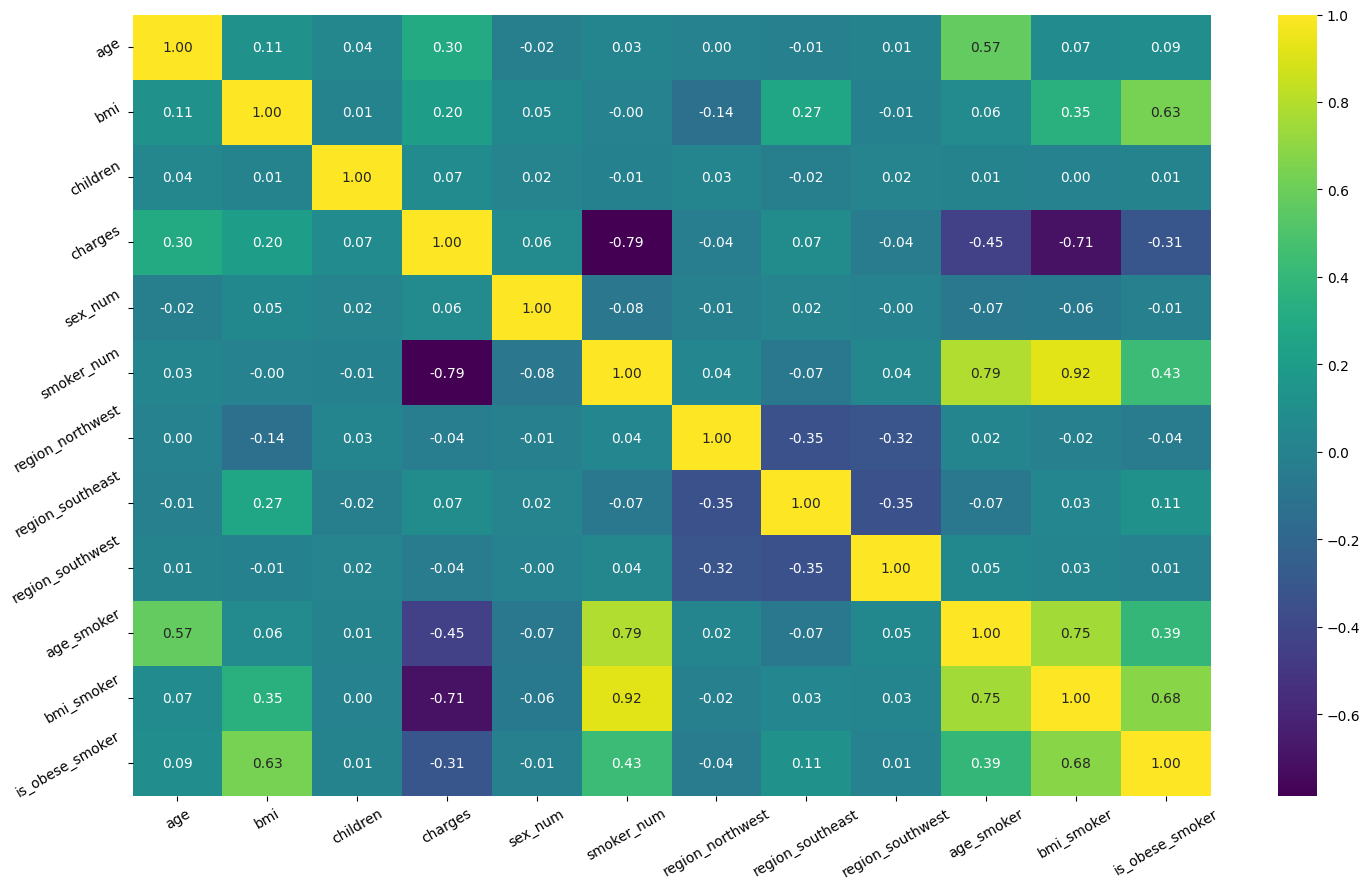

In [34]:
# Creating << NEW >> heatmap chart to analyze complete variables correlation
cols_num = df_WITH_outliers.select_dtypes(include=['number']).columns.tolist()
fig, ax = plt.subplots(figsize= (15, 9))
sns.heatmap(df_WITH_outliers[cols_num].corr(method="pearson"), annot=True, fmt=".2f", cmap="viridis", ax= ax).tick_params(rotation= 30)
plt.tight_layout()
plt.show()

### 6.3.1 Conclusion on New Features
- **bmi_smoker**: This new feature has a correlation of -0.71 with charges. This is significantly higher than the raw bmi correlation of 0.20. It confirms that BMI's impact on cost is mostly relevant when the individual is also a smoker.
- **age_smoke**: This interaction shows a -0.45 correlation. It captures that effect we saw in earlier scatter plots, where being an older smoker carries a much higher cost than just being older.
- **is_obese_smoker**: This has a -0.31 correlation. While slightly lower than the continuous interactions, it provides the model with a clear indicator for the highest-cost cluster.
- **smoker_num and bmi_smoker (0.92)**. In a linear model, this is called Multicollinearity.

* **Given the conclusion above**, I will finally drop the column **smoker_num** (Multicollinearity with bmi_smoker) and the **regions column** (they show near-zero correlation with the target variable 'charges').
    - **FINAL_COL_DATSET** = ['age', 'bim', 'children', 'charges', 'sex_num', 'age_smoker', 'bmi_smoker', is_obese_smoker']


In [35]:
FINAL_COL_DATSET = ['age', 'bmi', 'children', 'charges', 'sex_num', 'age_smoker', 'bmi_smoker', 'is_obese_smoker']
df_WITH_outliers = df_WITH_outliers[FINAL_COL_DATSET]

In [36]:
df_WITH_outliers.head()

,age,bmi,children,charges,sex_num,age_smoker,bmi_smoker,is_obese_smoker
0,19,27.900,0,16884.92400,0,0,0.000,0
1,18,33.770,1,1725.55230,1,18,33.770,1
2,28,33.000,3,4449.46200,1,28,33.000,1
3,33,22.705,0,21984.47061,1,33,22.705,0
4,32,28.880,0,3866.85520,1,32,28.880,0


## 6.4 Feature Scaling

In [37]:
# Divide the set into train and test

# df_WITH_outliers 
# df_WITHOUT_outliers 
				
predictors = ['age', 'bmi', 'children', 'sex_num', 'age_smoker', 'bmi_smoker', 'is_obese_smoker']
target = 'charges'

X_WITH_outliers = df_WITH_outliers.drop(target, axis = 1)[predictors]
# X_WITHOUT_outliers = df_WITHOUT_outliers.drop(target, axis = 1)[predictors]
y = df_WITH_outliers[target]

X_train_WITH_outliers, X_test_WITH_outliers, y_train, y_test = train_test_split(X_WITH_outliers, y, test_size = 0.2, random_state = 10)
# X_train_WITHOUT_outliers, X_test_WITHOUT_outliers = train_test_split(X_WITHOUT_outliers, test_size = 0.2, random_state = 10)

In [38]:
# Normalization and MIN_MAX Scaling

# X_train_WITH_outliers
# X_train_WITHOUT_outliers

# X_test_WITH_outliers
# X_test_WITHOUT_outliers

# WE NEED TO SAVE 3 OCCURRENCE: 1) DATASET PLANE (WITH NO CHANGES), 2) DATASET NORMALIZED, 3) DATASET MIN-MAX

## NORMALIZATION
### WITH OUTLIERS
norm_WITH_outliers = StandardScaler() # StandardScaler(), used to "normalize" or "resize" your data so that all your features are on the same scale. 
# .fit(), The "Learning"
norm_WITH_outliers.fit(X_train_WITH_outliers) # Phase. the scaler (or model) looks at your data and calculates the necessary parameters. It does not change the data; it only learns from it.

# .transform(), The "Applying" Phase.
# NOTE: .fit_transform() — The "Shortcut" --> This is simply a convenience method that does both steps at the same time on the same piece of data. --- Use this on your Training Data ---
X_train_WITH_outliers_norm = norm_WITH_outliers.transform(X_train_WITH_outliers) # This uses the parameters calculated during .fit() to actually modify the data.
X_train_WITH_outliers_norm = pd.DataFrame(X_train_WITH_outliers_norm, index = X_train_WITH_outliers.index, columns = predictors) # We need to convert to DataFrame the transform with this variable

X_test_WITH_outliers_norm = norm_WITH_outliers.transform(X_test_WITH_outliers)
X_test_WITH_outliers_norm = pd.DataFrame(X_test_WITH_outliers_norm, index = X_test_WITH_outliers.index, columns = predictors)

### WITHOUT OUTLIERS
# norm_WITHOUT_outliers = StandardScaler()
# norm_WITHOUT_outliers.fit(X_train_WITHOUT_outliers)

# X_train_WITHOUT_outliers_norm = norm_WITHOUT_outliers.transform(X_train_WITHOUT_outliers)
# X_train_WITHOUT_outliers_norm = pd.DataFrame(X_train_WITHOUT_outliers_norm, index = X_train_WITHOUT_outliers.index, columns = predictors)

# X_test_WITHOUT_outliers_norm = norm_WITHOUT_outliers.transform(X_test_WITHOUT_outliers)
# X_test_WITHOUT_outliers_norm = pd.DataFrame(X_test_WITHOUT_outliers_norm, index = X_test_WITHOUT_outliers.index, columns = predictors)


## SCALED MIN_MAX
### WITH OUTLIERS
scaler_WITH_outliers = MinMaxScaler() # MinMaxScaler is a scaling technique that transforms the data so that all values fall within a specific range, most commonly between 0 and 1.
scaler_WITH_outliers.fit(X_train_WITH_outliers)

X_train_WITH_outliers_scal = scaler_WITH_outliers.transform(X_train_WITH_outliers)
X_train_WITH_outliers_scal = pd.DataFrame(X_train_WITH_outliers_scal, index = X_train_WITH_outliers.index, columns = predictors)

X_test_WITH_outliers_scal = scaler_WITH_outliers.transform(X_test_WITH_outliers)
X_test_WITH_outliers_scal = pd.DataFrame(X_test_WITH_outliers_scal, index = X_test_WITH_outliers.index, columns = predictors)

### WITHOUT OUTLIERS
# scaler_WITHOUT_outliers = MinMaxScaler()
# scaler_WITHOUT_outliers.fit(X_train_WITHOUT_outliers)

# X_train_WITHOUT_outliers_scal = scaler_WITHOUT_outliers.transform(X_train_WITHOUT_outliers)
# X_train_WITHOUT_outliers_scal = pd.DataFrame(X_train_WITHOUT_outliers_scal, index = X_train_WITHOUT_outliers.index, columns = predictors)

# X_test_WITHOUT_outliers_scal = scaler_WITHOUT_outliers.transform(X_test_WITHOUT_outliers)
# X_test_WITHOUT_outliers_scal = pd.DataFrame(X_test_WITHOUT_outliers_scal, index = X_test_WITHOUT_outliers.index, columns = predictors)

# X_train_WITH_outliers
# X_train_WITH_outliers_norm
# X_train_WITH_outliers_scal
# X_train_WITHOUT_outliers
# X_train_WITHOUT_outliers_norm
# X_train_WITHOUT_outliers_scal

# X_test_WITH_outliers
# X_test_WITH_outliers_norm
# X_test_WITH_outliers_scal
# X_test_WITHOUT_outliers
# X_test_WITHOUT_outliers_norm
# X_test_WITHOUT_outliers_scal

### 6.4.1 Testing Data Consistency

In [39]:
print("Table with train data modified WITH outliers.")
print(tabulate(X_train_WITH_outliers.head(), headers= "keys", tablefmt= "psql"))

Table with train data modified WITH outliers.
+------+-------+-------+------------+-----------+--------------+--------------+-------------------+
|      |   age |   bmi |   children |   sex_num |   age_smoker |   bmi_smoker |   is_obese_smoker |
|------+-------+-------+------------+-----------+--------------+--------------+-------------------|
|  981 |    31 | 25.9  |          3 |         1 |            0 |         0    |                 0 |
|  906 |    44 | 32.34 |          1 |         0 |           44 |        32.34 |                 1 |
|   22 |    18 | 34.1  |          0 |         1 |           18 |        34.1  |                 1 |
| 1260 |    28 | 37.1  |          1 |         1 |           28 |        37.1  |                 1 |
| 1064 |    42 | 25.3  |          1 |         0 |           42 |        25.3  |                 0 |
+------+-------+-------+------------+-----------+--------------+--------------+-------------------+


In [40]:
print("Table with train data modified WITH outliers. Normalization of the data embedded.")
print(tabulate(X_train_WITH_outliers_norm.head(), headers= "keys", tablefmt= "psql"))

Table with train data modified WITH outliers. Normalization of the data embedded.
+------+-----------+-----------+------------+-----------+--------------+--------------+-------------------+
|      |       age |       bmi |   children |   sex_num |   age_smoker |   bmi_smoker |   is_obese_smoker |
|------+-----------+-----------+------------+-----------+--------------+--------------+-------------------|
|  981 | -0.57529  | -0.785307 |  1.60676   |  0.997198 |    -1.5359   |   -1.79023   |         -0.850996 |
|  906 |  0.350356 |  0.254214 | -0.0689729 | -1.00281  |     0.631271 |    0.584668  |          1.17509  |
|   22 | -1.50094  |  0.538307 | -0.906837  |  0.997198 |    -0.649332 |    0.713914  |          1.17509  |
| 1260 | -0.788901 |  1.02256  | -0.0689729 |  0.997198 |    -0.156792 |    0.93422   |          1.17509  |
| 1064 |  0.207949 | -0.882157 | -0.0689729 | -1.00281  |     0.532763 |    0.0676847 |         -0.850996 |
+------+-----------+-----------+------------+---------

### 6.4.2 Saving all of the DATASET
    train, test with all the variance we have created.

In [41]:
# DATASETS that have been created so far in previous steps from the feature engineering

X_train_WITH_outliers.to_excel("../data/processed/X_train_WITH_outliers.xlsx", index = False)
X_train_WITH_outliers_norm.to_excel("../data/processed/X_train_WITH_outliers_norm.xlsx", index = False)
X_train_WITH_outliers_scal.to_excel("../data/processed/X_train_WITH_outliers_scal.xlsx", index = False)
# X_train_WITHOUT_outliers.to_excel("../data/processed/X_train_WITHOUT_outliers.xlsx", index = False)
# X_train_WITHOUT_outliers_norm.to_excel("../data/processed/X_train_WITHOUT_outliers_norm.xlsx", index = False)
# X_train_WITHOUT_outliers_scal.to_excel("../data/processed/X_train_WITHOUT_outliers_scal.xlsx", index = False)

X_test_WITH_outliers.to_excel("../data/processed/X_test_WITH_outliers.xlsx", index = False)
X_test_WITH_outliers_norm.to_excel("../data/processed/X_test_WITH_outliers_norm.xlsx", index = False)
X_test_WITH_outliers_scal.to_excel("../data/processed/X_test_WITH_outliers_scal.xlsx", index = False)
# X_test_WITHOUT_outliers.to_excel("../data/processed/X_test_WITHOUT_outliers.xlsx", index = False)
# X_test_WITHOUT_outliers_norm.to_excel("../data/processed/X_test_WITHOUT_outliers_norm.xlsx", index = False)
# X_test_WITHOUT_outliers_scal.to_excel("../data/processed/X_test_WITHOUT_outliers_scal.xlsx", index = False)

y_train.to_excel("../data/processed/y_train.xlsx", index = False)
y_test.to_excel("../data/processed/y_test.xlsx", index = False)

# SCALERS --> Saving the models

with open("../models/norm_WITH_outliers.pkl", "wb") as file:
  pickle.dump(norm_WITH_outliers, file)
# with open("../models/norm_WITHOUT_outliers.pkl", "wb") as file:
#   pickle.dump(norm_WITHOUT_outliers, file)
with open("../models/scaler_WITH_outliers.pkl", "wb") as file:
  pickle.dump(scaler_WITH_outliers, file)
# with open("../models/scaler_WITHOUT_outliers.pkl", "wb") as file:
#   pickle.dump(scaler_WITHOUT_outliers, file)

# Step 7. Feature Selection
    - Test all dataset "roughly" and I will keep the best score. Keeping all variable.
    - The model need to be trained entirely.
    - If results meet desire objective --> YEAH! WE?VE FINISHED.
    - If not, move back to step 6 and repeat the process from step 2.

In [42]:
# sklearn: professional-grade "toolbox" that provides a consistent way to build, test, and deploy predictive models.
# f_classif: is a function that performs a statistical test called ANOVA (Analysis of Variance).
# SelectKBest: While f_classif does the math, SelectKBest is the "manager" that acts on those numbers.
 

X_train = X_train_WITH_outliers.copy()
X_test = X_test_WITH_outliers.copy()

# With k = 5, We tell it to use f_classif as the scorer and pick the top 5 features, to avoid "overwhelming" the model
selection_model = SelectKBest(score_func=f_regression, k = 5)
selection_model.fit(X_train, y_train)

# .get_support(), This returns a list of "True/False" values (e.g., [True, False, True...]). This is how one "remember" which column names were the winners.
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

print("Table with the top 5 columns slected for the Machine Learning model.")
print(tabulate(X_train_sel.head(), headers= "keys", tablefmt= "psql"))

Table with the top 5 columns slected for the Machine Learning model.
+----+-------+-------+--------------+--------------+-------------------+
|    |   age |   bmi |   age_smoker |   bmi_smoker |   is_obese_smoker |
|----+-------+-------+--------------+--------------+-------------------|
|  0 |    31 | 25.9  |            0 |         0    |                 0 |
|  1 |    44 | 32.34 |           44 |        32.34 |                 1 |
|  2 |    18 | 34.1  |           18 |        34.1  |                 1 |
|  3 |    28 | 37.1  |           28 |        37.1  |                 1 |
|  4 |    42 | 25.3  |           42 |        25.3  |                 0 |
+----+-------+-------+--------------+--------------+-------------------+


## 7.2 Check the Winners Column
It is very helpful to see which 5 columns were chosen and how much better they are than the ones that were dropped.

In [43]:
# Create a small table of the scores
features_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': selection_model.scores_
}).sort_values(by='Score', ascending=False)

print("Table that shows the score used in order to select the top 5 columns for ML model")
print(tabulate(features_scores, headers= "keys", tablefmt= "psql"))

Table that shows the score used in order to select the top 5 columns for ML model
+----+-----------------+------------+
|    | Feature         |      Score |
|----+-----------------+------------|
|  5 | bmi_smoker      | 1092.77    |
|  4 | age_smoker      |  274.865   |
|  6 | is_obese_smoker |  119.073   |
|  0 | age             |   94.6307  |
|  1 | bmi             |   43.0501  |
|  2 | children        |    7.93806 |
|  3 | sex_num         |    4.00894 |
+----+-----------------+------------+


In [44]:
# Create a dataframe to compare scores and p-values
feature_stats = pd.DataFrame({
    'Feature': X_train.columns,
    'F-Score': selection_model.scores_,
    'p-value': selection_model.pvalues_
})

# Format p-values to be readable (avoiding scientific notation like 1e-10)
feature_stats['p-value'] = feature_stats['p-value'].apply(lambda x: format(x, '.5f'))

print("Table adding extra information on p-values. It represents the probability - relationship between variables.")
print(tabulate(feature_stats.sort_values(by='F-Score', ascending=False), headers= "keys", tablefmt= "psql"))

Table adding extra information on p-values. It represents the probability - relationship between variables.
+----+-----------------+------------+-----------+
|    | Feature         |    F-Score |   p-value |
|----+-----------------+------------+-----------|
|  5 | bmi_smoker      | 1092.77    |   0       |
|  4 | age_smoker      |  274.865   |   0       |
|  6 | is_obese_smoker |  119.073   |   0       |
|  0 | age             |   94.6307  |   0       |
|  1 | bmi             |   43.0501  |   0       |
|  2 | children        |    7.93806 |   0.00493 |
|  3 | sex_num         |    4.00894 |   0.04551 |
+----+-----------------+------------+-----------+


# Step 8. Best Model Selection
## 8.1 Reading the Processed Dataset

In [45]:
# We will use the train set to train the model.

X_train_WITH_outliers = pd.read_excel("../data/processed/X_train_WITH_outliers.xlsx")
X_train_WITH_outliers_norm = pd.read_excel("../data/processed/X_train_WITH_outliers_norm.xlsx")
X_train_WITH_outliers_scal = pd.read_excel("../data/processed/X_train_WITH_outliers_scal.xlsx")
# X_train_WITHOUT_outliers = pd.read_excel("../data/processed/X_train_WITHOUT_outliers.xlsx")
# X_train_WITHOUT_outliers_norm = pd.read_excel("../data/processed/X_train_WITHOUT_outliers_norm.xlsx")
# X_train_WITHOUT_outliers_scal = pd.read_excel("../data/processed/X_train_WITHOUT_outliers_scal.xlsx")
y_train = pd.read_excel("../data/processed/y_train.xlsx")

In [46]:
datasets = [
    X_train_WITH_outliers,
    X_train_WITH_outliers_norm,
    X_train_WITH_outliers_scal
    ]

# X_train_WITHOUT_outliers,
# X_train_WITHOUT_outliers_norm,
# X_train_WITHOUT_outliers_scal

models = []
metrics = []
for dataset in datasets:
  model = LinearRegression() # Linear Regretion
  model.fit(dataset, y_train) # To train the model
  y_pred = model.predict(dataset)
  metric = r2_score(y_train, y_pred)
  metrics.append(metric)
  models.append(model)

best_metric = max(metrics)
best_index = metrics.index(best_metric)
print(f"This is the list of R2 score: {metrics}\nThe best metric: {best_metric}\nThe Best index: {best_index}")
print("The best DataSet is: ", datasets[best_index])

This is the list of R2 score: [0.8338170022386019, 0.8338170022386019, 0.8338170022386018]
The best metric: 0.8338170022386019
The Best index: 0
The best DataSet is:        age     bmi  children  sex_num  age_smoker  bmi_smoker  is_obese_smoker
0      31  25.900         3        1           0       0.000                0
1      44  32.340         1        0          44      32.340                1
2      18  34.100         0        1          18      34.100                1
3      28  37.100         1        1          28      37.100                1
4      42  25.300         1        0          42      25.300                0
...   ...     ...       ...      ...         ...         ...              ...
1064   24  29.925         0        0          24      29.925                0
1065   55  21.500         1        1          55      21.500                0
1066   51  25.800         1        0          51      25.800                0
1067   18  30.305         0        0          18     

## 8.2 Initialization and Training of the Model

In [47]:
# 1. Select the best model and matching test set
best_model = models[best_index]
# Note: If best_index is 0, we use X_test_WITH_outliers
test_datasets = [X_test_WITH_outliers, X_test_WITH_outliers_norm, X_test_WITH_outliers_scal]
X_test_final = test_datasets[best_index]

# 2. Final Evaluation (The Real Test)
y_test_pred = best_model.predict(X_test_final)
final_r2 = r2_score(y_test, y_test_pred)
final_mae = mean_absolute_error(y_test, y_test_pred)

print(f"--- FINAL MODEL RESULTS ---")
print(f"Final R2 Score (Test Set): {final_r2:.4f}")
print(f"Mean Absolute Error: ${final_mae:.2f}")

# 3. Show Feature Importance (The Weights)
importance = pd.DataFrame({
    'Feature': X_test_final.columns,
    'Weight ($)': best_model.coef_.flatten()
}).sort_values(by='Weight ($)', ascending=False)

# Add the Intercept (Base Price) - it also needs to be flattened or cast to float
base_price = float(best_model.intercept_[0])
print(f"Base Insurance Price (Intercept): ${base_price:.2f}")
print("\nFeature Weights:")
print(importance)

--- FINAL MODEL RESULTS ---
Final R2 Score (Test Set): 0.7913
Mean Absolute Error: $3130.43
Base Insurance Price (Intercept): $-8300.47

Feature Weights:
           Feature   Weight ($)
1              bmi  1107.229650
2         children   562.182304
0              age   174.054168
4       age_smoker   109.335932
3          sex_num  -573.801242
5       bmi_smoker  -914.107250
6  is_obese_smoker -1607.430714


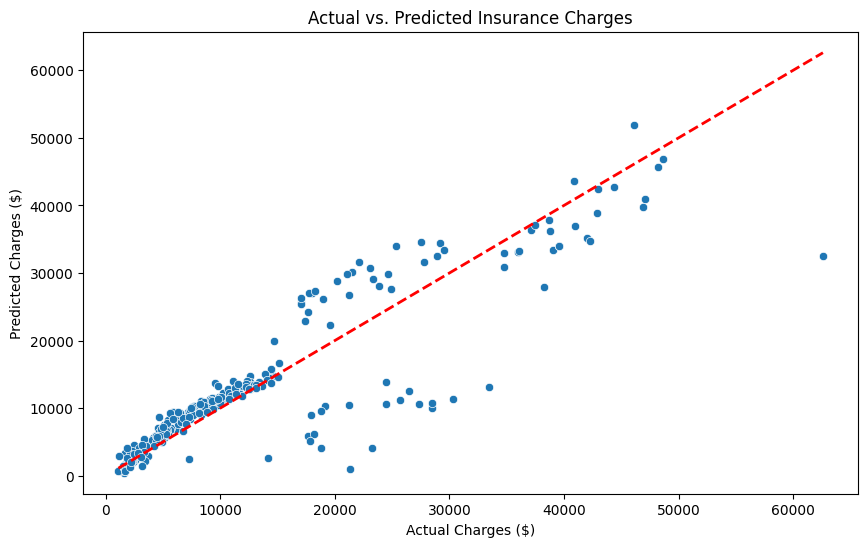

In [48]:
plt.figure(figsize= (10, 6))
sns.scatterplot(x= y_test.flatten() if hasattr(y_test, 'flatten') else y_test, y= y_test_pred.flatten())
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth= 2)
plt.title('Actual vs. Predicted Insurance Charges')
plt.xlabel('Actual Charges ($)')
plt.ylabel('Predicted Charges ($)')
plt.show()

### 8.2.1 Conclusion Insurance Cost Prediction Model
- R^2 score of 0.83 on **the training data**.
- The R^2 score is 0.79, which is quite good **for the test set**. The negative weights are a result of Multicollinearity between your interaction terms.
- The engineered features (bmi_smoker and is_obese_smoker) have negative weights, which means the model thinks being an obese smoker lowers your insurance cost.
- On average, the model's predictions are within $3,130 of the actual cost **(Mean Absolute Error)**.
- **The logic**: As we saw before, these features are so highly correlated. It's giving a huge positive weight to bmi ($1107) and then "correcting" it by subtracting weight from the smoker versions to make the final math work.
- **The Intercept**: A negative intercept ($-8300$) is also a sign of this. It's mathematically "correct" for the training data, but it doesn't make logical sense (you can't have a negative insurance bill).

# Step 9. Regularized Linear Models
- Because these models are sensitive to the scale of the data, I will use the scaled datasets (X_train_WITH_outliers_scal) built inprevious steps.

In [49]:
# 1. Initialize models (alpha=1.0 is the standard starting penalty)
ridge = Ridge(alpha= 1.0)
lasso = Lasso(alpha= 1.0)

# 2. Fit models on SCALED data
ridge.fit(X_train_WITH_outliers_scal, y_train)
lasso.fit(X_train_WITH_outliers_scal, y_train)

# 3. Evaluate R2 Scores
ridge_r2 = r2_score(y_test, ridge.predict(X_test_WITH_outliers_scal))
lasso_r2 = r2_score(y_test, lasso.predict(X_test_WITH_outliers_scal))

print(f"Ridge R2 Score: {ridge_r2:.4f}")
print(f"Lasso R2 Score: {lasso_r2:.4f}")

Ridge R2 Score: 0.7916
Lasso R2 Score: 0.7914


## 9.1 Inspecting the "Logic" (Weights)

In [50]:
# Create a comparison table for the weights
weights_comp = pd.DataFrame({
    'Feature': X_train_WITH_outliers_scal.columns,
    'Ridge_Weight': ridge.coef_.flatten(),
    'Lasso_Weight': lasso.coef_.flatten()
})

print("\n--- Weight Comparison ---")
print(weights_comp.sort_values(by='Lasso_Weight', ascending=False))


--- Weight Comparison ---
           Feature  Ridge_Weight  Lasso_Weight
1              bmi  36711.481747  40989.619885
0              age  11187.515194   8120.032676
4       age_smoker   1312.753198   6784.106719
2         children   2708.086284   2791.007048
3          sex_num   -489.386562   -567.580150
6  is_obese_smoker  -1866.324392  -1604.903187
5       bmi_smoker -41615.575324 -48328.082194


## 9.2 Code for RidgeCV and LassoCV

In [51]:
# 1. Define a range of alphas to test (from very small to very large)
alphas = np.logspace(-2, 4, 50) 

# 2. Initialize the Cross-Validation models
ridge_cv = RidgeCV(alphas= alphas, scoring='r2')
lasso_cv = LassoCV(alphas= alphas, cv= 5, random_state= 10)

# 3. Fit on the SCALED data
ridge_cv.fit(X_train_WITH_outliers_scal, y_train.values.ravel())
lasso_cv.fit(X_train_WITH_outliers_scal, y_train.values.ravel())

print(f"Best Ridge Alpha: {ridge_cv.alpha_}")
print(f"Best Lasso Alpha: {lasso_cv.alpha_}")

# 4. Compare the new weights
weights_cv = pd.DataFrame({
    'Feature': X_train_WITH_outliers_scal.columns,
    'RidgeCV_Weight': ridge_cv.coef_.flatten(),
    'LassoCV_Weight': lasso_cv.coef_.flatten()
})

print("\n--- Optimized Weight Comparison ---")
print(weights_cv.sort_values(by='LassoCV_Weight', ascending=False))

Best Ridge Alpha: 0.023299518105153717
Best Lasso Alpha: 0.01

--- Optimized Weight Comparison ---
           Feature  RidgeCV_Weight  LassoCV_Weight
1              bmi    41029.676075    41154.060127
0              age     8103.820487     8007.633192
4       age_smoker     6825.885626     6995.356041
2         children     2807.853373     2810.712286
3          sex_num     -571.501722     -573.739001
6  is_obese_smoker    -1616.214884    -1607.405949
5       bmi_smoker   -48359.259494   -48564.123555


## 9.3 The Final Performance Report

In [52]:
# Dictionary to store results
results = {}

# List of models and their corresponding test sets
eval_list = [
    ("Linear (Original)", models[0], X_test_WITH_outliers),
    ("Ridge (Alpha= 1)", ridge, X_test_WITH_outliers_scal),
    ("Lasso (Alpha= 1)", lasso, X_test_WITH_outliers_scal),
    ("Ridge CV (Optimized)", ridge_cv, X_test_WITH_outliers_scal),
    ("Lasso CV (Optimized)", lasso_cv, X_test_WITH_outliers_scal)
]

for name, model, X_test_data in eval_list:
    y_pred = model.predict(X_test_data)
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {"R2": round(r2, 4), "MAE ($)": round(mae, 2)}

# Convert to DataFrame for a clean display
final_comparison = pd.DataFrame(results).T
print(final_comparison)

                          R2  MAE ($)
Linear (Original)     0.7913  3130.43
Ridge (Alpha= 1)      0.7916  3204.86
Lasso (Alpha= 1)      0.7914  3130.51
Ridge CV (Optimized)  0.7914  3131.66
Lasso CV (Optimized)  0.7913  3130.43


### 9.3.1 Final Conclusions
- **All five models** are performing almost identically. It means your original Linear Regression was already capturing the maximum amount of signal available in these features.
- **The winner (MAE)**: Technically, the Linear (Original) and Lasso CV are tied for the best Mean Absolute Error ($3,130.43).
- **Lasso’s Role**: Since Lasso CV gave the exact same result as the Linear model, it confirms that all the features chosen in the engineered ones like is_obese_smoker, are contributing to the prediction.
- **Ridge (Alpha=1) Outlier**: Notice that the Ridge (Alpha=1) model actually has a slightly higher MAE ($3,204). This might suggests that a penalty of 1.0 was a bit too aggressive, hurting the accuracy slightly.